# Import packages

In [7]:
!gsutil cp gs://tactile-paving-bucket/train_images.zip train_images.zip
!gsutil cp gs://tactile-paving-bucket/test_images.zip test_images.zip

!unzip train_images.zip -d train_images
!unzip test_images.zip -d test_images

!rm -rf train_images.zip
!rm -rf test_images.zip

Copying gs://tactile-paving-bucket/train_images.zip...
| [1 files][186.3 MiB/186.3 MiB]                                                
Operation completed over 1 objects/186.3 MiB.                                    
Copying gs://tactile-paving-bucket/test_images.zip...
/ [1 files][ 33.4 MiB/ 33.4 MiB]                                                
Operation completed over 1 objects/33.4 MiB.                                     
Archive:  train_images.zip
   creating: train_images/image/
  inflating: train_images/image/6g_0GBpuOesUUKhWe9dwEw.jpg  
  inflating: train_images/image/EFDVPgr0PTR5hApHh3kEur.jpg  
  inflating: train_images/image/Sxe3Bq2t9uRu_jNvhw4GKQ.jpg  
  inflating: train_images/image/riZGMz3il2lShgSZLkiyEX.jpg  
  inflating: train_images/image/oF0eTgwvTcp3ZHSvm0Mkji.jpg  
  inflating: train_images/image/Awa5ZwitwX8FGlKqT0ndIG.jpg  
  inflating: train_images/image/WhpfpGmj3saGsUMSKIjsWA.jpg  
  inflating: train_images/image/JPBSIRJScBmGT9o1QZ83c1.jpg  
  inflating: trai

In [8]:
!pip install transformers
!pip install torch
!pip install torchvision
!pip install timm
!pip install pycocotools
!pip install tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 37.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 749.3/749.3 KB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 KB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 111.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.2/895.2 KB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 KB 1.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 KB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=370023 sha256=13d83885646b9118356e5dc48580d2245926f95f422e5ac1f6c569c82ff2f6d1
  Stored in directory: /home/jupyter/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bb

In [12]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
from PIL import Image, ImageDraw
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
import json
from transformers import AdamW, get_scheduler
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
import gc

In [2]:
torch.cuda.is_available()

True

# Load in COCO dataset and turn into DataLoader

In [3]:
path_to_train_data = "train_images/image" # for cloud instance
path_to_test_data = "test_images/image"

# path_to_train_data = "crowd4access-images/crowd4access-images/trainval/image" # for local
# path_to_test_data = "crowd4access-images/crowd4access-images/test/image"

In [4]:
class CocoDetection(torchvision.datasets.CocoDetection):
    """
    Huge thank you to Niels Rogge, all this was written by him except for me changing filepaths
    """
    def __init__(self, img_folder: str, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "custom_train.json" if train else "custom_test.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [39]:
feature_extractor = DetrFeatureExtractor.from_pretrained(
    "facebook/detr-resnet-50"
    )

train_dataset = CocoDetection(img_folder=path_to_train_data, feature_extractor=feature_extractor)
test_dataset = CocoDetection(img_folder=path_to_test_data, feature_extractor=feature_extractor, train=False)

id2label = {k: v["name"] for k, v in train_dataset.coco.cats.items()}

model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", 
    num_labels=len(id2label), 
    ignore_mismatched_sizes=True,
    num_queries=10
    )

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- model.query_position_embeddings.weight: found shape torch.Size([100, 256]) in the checkpoint and torch.Size([10, 256]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image 1515


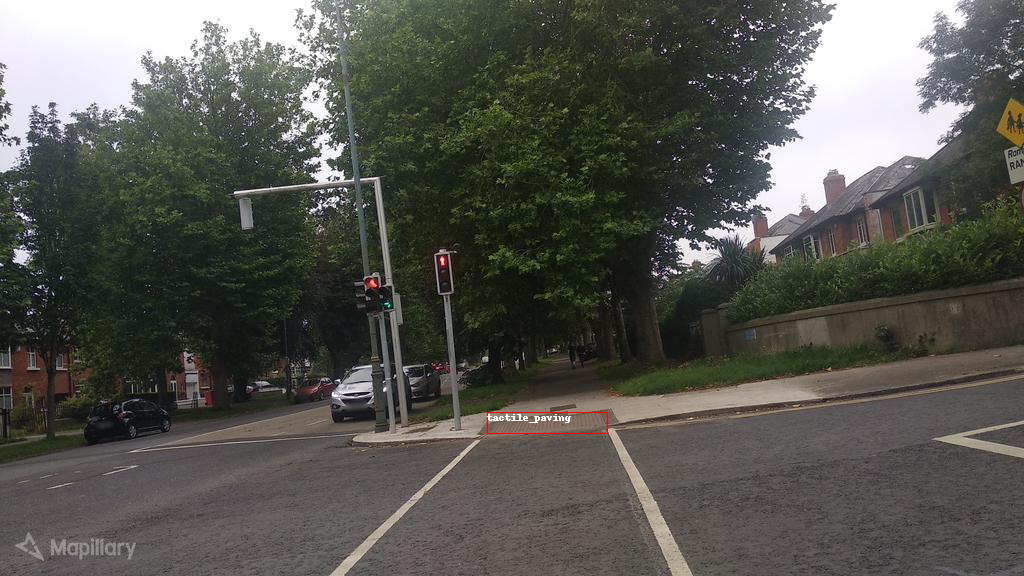

In [40]:
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print(f'Image {image_id}')
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(path_to_train_data, image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [41]:
def collate_fn(batch):
    pixel_values = [item[0] for item in batch]

    encoding = feature_extractor.pad_and_create_pixel_mask(
        pixel_values,
        return_tensors="pt"
    )
    
    labels = [item[1] for item in batch]

    batch = {}

    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    
    return batch

In [42]:
train_dataloader = DataLoader(
    train_dataset,
    collate_fn=collate_fn,
    batch_size=2,
    shuffle=True,
    num_workers=4
)

val_dataloader = DataLoader(
    test_dataset,
    collate_fn=collate_fn,
    batch_size=2
)

# Training!

In [43]:
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 50
num_training_steps = num_epochs * len(train_dataloader)
# lr_scheduler = get_scheduler(
#     "linear",
#     optimizer=optimizer,
#     num_warmup_steps=0,
#     num_training_steps=num_training_steps
# )
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model.to(device)

progress_bar = tqdm(range(num_training_steps))

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/45050 [00:00<?, ?it/s]

In [44]:
device

device(type='cuda')

In [45]:
torch.cuda.empty_cache()
# del train_dataset
# del test_dataset
gc.collect()

25031

In [46]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 25085), started 0:06:55 ago. (Use '!kill 25085' to kill it.)

In [47]:
path_to_weights = "detr_tactile-paving"
writer = SummaryWriter()

best_vloss = 100000
for epoch in range(num_epochs):

    # training loop
    model.train(True)
    running_loss = 0.
    for i, batch in enumerate(train_dataloader):
        
        pixel_values = batch["pixel_values"]
        pixel_values = pixel_values.to(device)
        pixel_mask = batch["pixel_mask"]
        pixel_mask = pixel_mask.to(device)
        labels = []

        for label in batch["labels"]:
            labels.append({k: v.to(device) for k, v in label.items()})

        optimizer.zero_grad()

        outputs = model(
            pixel_values=pixel_values,
            pixel_mask=pixel_mask,
            labels=labels
        )
        loss_dict = outputs.loss_dict
        loss = outputs.loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        
        progress_bar.update(1)

        
    # validation
    model.train(False)
    running_vloss = 0.
    for j, batch in enumerate(val_dataloader):
        pixel_values = batch["pixel_values"].to(device)
        # pixel_values = pixel_values.to(device)
        pixel_mask = batch["pixel_mask"].to(device)
        # pixel_mask = pixel_mask.to(device)
        labels = []

        for label in batch["labels"]:
            labels.append({k: v.to(device) for k, v in label.items()})

        outputs = model(
            pixel_values=pixel_values,
            pixel_mask=pixel_mask,
            labels=labels
        )
        val_loss_dict = outputs.loss_dict
        val_loss = outputs.loss
        running_vloss += loss.item()

    avg_loss = running_loss / (i + 1)
    avg_vloss = running_vloss / (j + 1)

    # log results
    writer.add_scalar("train_avg_loss", avg_loss, epoch)
    writer.add_scalar("val_avg_loss", avg_vloss, epoch)

    for k,v in loss_dict.items(): # reports last train loss
          writer.add_scalar("train_" + k, v.item(), epoch)
            
    for k,v in val_loss_dict.items(): # reports last val loss
        writer.add_scalar("val_" + k, v.item(), epoch)
        
    writer.flush()

    if avg_vloss < best_vloss:
        better_idx = epoch
        best_vloss = avg_vloss
        print("Better val loss found! Updating...")
        model.save_pretrained(path_to_weights)
    elif epoch > better_idx + 5: # if vloss doesn't improve for 5 epochs, stop training
        print("Early stopping engaged. Average val loss hasn't improved for 3 epochs. Reverting to best model")
        break

writer.close()

Better val loss found! Updating...
Better val loss found! Updating...
Better val loss found! Updating...
Early stopping engaged. Average val loss hasn't improved for 3 epochs. Reverting to best model


In [67]:
!gsutil cp -r runs gs://tactile-paving-bucket/runs

Copying file://runs/Mar07_18-43-47_tactile-paving/events.out.tfevents.1646678627.tactile-paving.2667.2 [Content-Type=application/octet-stream]...
Copying file://runs/Mar07_18-43-09_tactile-paving/events.out.tfevents.1646678589.tactile-paving.2667.1 [Content-Type=application/octet-stream]...
Copying file://runs/Mar07_20-52-18_tactile-paving/events.out.tfevents.1646686338.tactile-paving.2667.3 [Content-Type=application/octet-stream]...
Copying file://runs/Mar07_18-42-01_tactile-paving/events.out.tfevents.1646678521.tactile-paving.2667.0 [Content-Type=application/octet-stream]...
/ [4 files][ 14.4 KiB/ 14.4 KiB]                                                
Operation completed over 4 objects/14.4 KiB.                                     


In [55]:
!gsutil cp -r detr_tactile-paving gs://tactile-paving-bucket/detr_tactile-paving

Copying file://detr_tactile-paving/pytorch_model.bin [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

Copying file://detr_tactile-paving/config.json [Content-Type=application/json]...
Copying file://detr_tactile-paving/.ipynb_checkpoints/config-checkpoint.json [Content-Type=application/json]...
| [3 files][158.8 MiB/15

In [68]:
loaded_model = DetrForObjectDetection.from_pretrained("detr_tactile-paving")

In [79]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=0.9):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [69]:
loaded_model.to(device)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrTimmConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (act2): ReLU(inplace=True)
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn3): DetrFrozenBatchNorm2d()
              (act3): ReLU(

In [49]:
import matplotlib.pyplot as plt
# loaded_model.to(device)

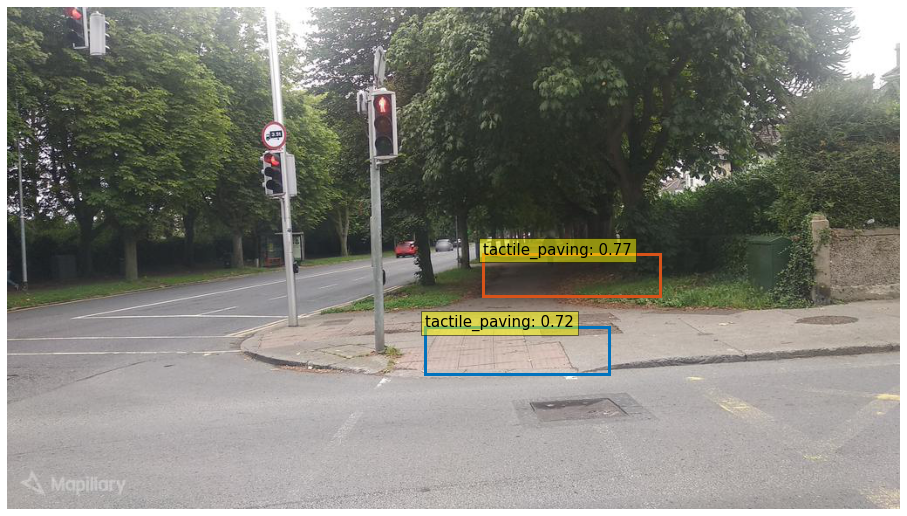

In [85]:
pixel_values, target = test_dataset[200]
pixel_values = pixel_values.unsqueeze(0).to(device)
outputs = loaded_model(pixel_values=pixel_values, pixel_mask=None)

image_id = target['image_id'].item()
image = test_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(path_to_test_data, image['file_name']))

visualize_predictions(image, outputs, threshold=0.7)